# patient-level ROC-AUC计算

=== 5-Fold Patient-Level AUC (mean ± std) ===
      BCL2: 0.8335 ± 0.0562
       MYC: 0.8641 ± 0.0277
      BCL6: 0.7948 ± 0.0191
  macro-avg: 0.8308 ± 0.0232


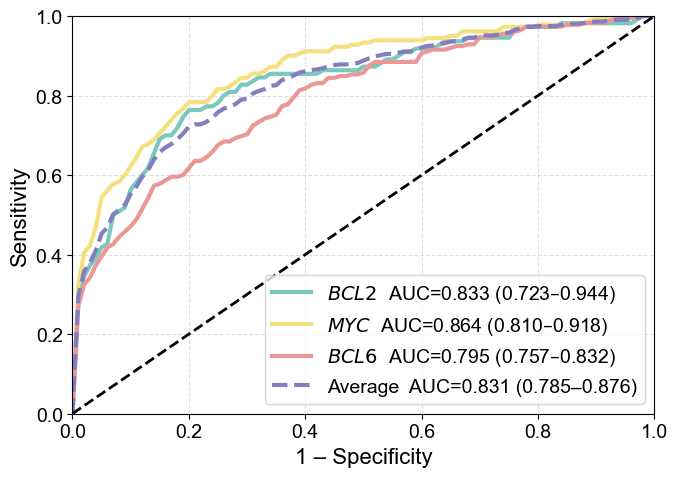

ROC 曲线已保存至 ./evaluation/SXH_clinic/SXH_clinic_ROC_patient.pdf


In [12]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
5-fold ROC-AUC (patient level) for BCL2 / MYC / BCL6
author : you
date   : 2025-06-26
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import roc_curve, auc
from pathlib import Path

# --------------------------------------------------------------
# 0. 参数与字体
# --------------------------------------------------------------
center_name  = 'SXH_clinic'
N_FOLDS      = 5
CSV_TPL      = f'./results/{center_name}/s_{{}}_checkpoint.csv'
MAP_PATH     = './dataset_csv/SXH_with_mutation.csv'   # slide ↔ case 对应表（含患者真值标签）
SAVE_PATH    = f'./evaluation/{center_name}/{center_name}_ROC_patient.pdf'

agg_prob = "mean"      # slide→patient 的概率聚合方式：mean / max / median ...

rcParams['font.family'] = 'DejaVu Sans'
AXIS_LABEL_SIZE = 12

# --------------------------------------------------------------
# 1. 读取 slide→case 映射 & 患者真值
# --------------------------------------------------------------
map_df = pd.read_csv(MAP_PATH, dtype=str)          # case_id, slide_id, BCL2 ...
label_cols_raw = ["BCL2", "MYC", "BCL6"]           # 原始列名
map_df[label_cols_raw] = map_df[label_cols_raw].astype(int)

fold_auc = []
interp_tprs = []
fold_macro_auc = []
interp_tprs_macro = []
# 为后续一致性，加前缀 label_
for lab in label_cols_raw:
    map_df[f"label_{lab}"] = map_df[lab]

map_df = map_df[['case_id', 'slide_id'] + [f"label_{x}" for x in label_cols_raw]]

# --------------------------------------------------------------
# 2. 遍历 5 个 fold，先做 patient-level 聚合
# --------------------------------------------------------------
fpr_grid = np.linspace(0, 1, 101)

for fold in range(N_FOLDS):
    slide_df = pd.read_csv(CSV_TPL.format(fold))

    # ⬇️ ① 删掉预测文件中的 label_* 列，避免与映射表重名
    slide_df = slide_df.drop(columns=[c for c in slide_df.columns
                                      if c.startswith('label_')],
                             errors='ignore')

    # --- ② 合并 case_id ---
    merged = slide_df.merge(map_df, on='slide_id', how='inner')

    # --- ③ 按 case_id 聚合 ---
    prob_cols  = [c for c in merged.columns if c.startswith('prob_')]
    label_cols = [f"label_{x}" for x in label_cols_raw]

    agg_dict = {c: agg_prob for c in prob_cols}   # 概率平均
    agg_dict.update({c: "max" for c in label_cols})  # label 取 max

    patient_df = merged.groupby('case_id', as_index=False).agg(agg_dict)

    # --- 2.3 本 fold 计算 ROC ---
    auc_dict, tpr_dict = {}, {}
    for prob_col, label_col in zip(prob_cols, label_cols):
        fpr, tpr, _ = roc_curve(patient_df[label_col], patient_df[prob_col])
        auc_dict[label_col] = auc(fpr, tpr)

        tpr_interp = np.interp(fpr_grid, fpr, tpr)
        tpr_interp[0], tpr_interp[-1] = 0.0, 1.0
        tpr_dict[label_col] = tpr_interp

    fold_auc.append(auc_dict)
    interp_tprs.append(tpr_dict)

    fold_macro_auc.append(np.mean(list(auc_dict.values())))
    interp_tprs_macro.append(np.vstack(list(tpr_dict.values())).mean(axis=0))

# --------------------------------------------------------------
# 3. 折间平均 & 方差
# --------------------------------------------------------------
mean_auc = {lc: np.mean([d[lc] for d in fold_auc]) for lc in label_cols}
std_auc  = {lc: np.std ([d[lc] for d in fold_auc], ddof=1) for lc in label_cols}

mean_auc_macro = np.mean(fold_macro_auc)
std_auc_macro  = np.std (fold_macro_auc, ddof=1)

mean_tpr       = {lc: np.vstack([d[lc] for d in interp_tprs]).mean(axis=0)
                  for lc in label_cols}
mean_tpr_macro = np.vstack(interp_tprs_macro).mean(axis=0)

# --------------------------------------------------------------
# 4. 打印结果
# --------------------------------------------------------------
print('=== 5-Fold Patient-Level AUC (mean ± std) ===')
for lc in label_cols:
    print(f'{lc.replace("label_", ""):>10}: {mean_auc[lc]:.4f} ± {std_auc[lc]:.4f}')
print(f'  macro-avg: {mean_auc_macro:.4f} ± {std_auc_macro:.4f}')

# ----------------------------------------------------------
# 5. 绘制 ROC 曲线（按你指定风格）
# ----------------------------------------------------------
plt.figure(figsize=(7, 5))

# ---- 全局字号 ----
plt.rcParams.update({
    'font.family'      : 'Arial',
    'font.size'        : 14,
    'axes.labelsize'   : 16,
    'xtick.labelsize'  : 14,
    'ytick.labelsize'  : 14,
    'legend.fontsize'  : 14
})

colors = ['#7AC9BC', '#F4E07E', '#EB9798']   # BCL2 / MYC / BCL6

# ---- 单基因曲线 ----
for idx, lc in enumerate(label_cols):
    m, s = mean_auc[lc], std_auc[lc]
    lo, hi = m - 1.96*s, m + 1.96*s
    gene = r'$\it{' + lc.replace('label_', '') + '}$'   # 斜体
    plt.plot(fpr_grid, mean_tpr[lc],
             color=colors[idx], lw=3,
             label=f'{gene}  AUC={m:.3f} ({lo:.3f}–{hi:.3f})')

# ---- macro-average ----
lo_macro, hi_macro = mean_auc_macro - 1.96*std_auc_macro, \
                     mean_auc_macro + 1.96*std_auc_macro
plt.plot(fpr_grid, mean_tpr_macro,
         color='#827EC0', lw=3, linestyle='--',
         label=f'Average  AUC={mean_auc_macro:.3f} ({lo_macro:.3f}–{hi_macro:.3f})')

# ---- 对角线 ----
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# ---- 坐标轴 ----
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('1 – Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right', frameon=True, shadow=False)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()

Path(SAVE_PATH).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(SAVE_PATH, dpi=300, bbox_inches='tight')
plt.show()
print(f'ROC 曲线已保存至 {SAVE_PATH}')

# patient-level PR-AUC

=== 5-Fold Patient-Level AP (mean ± std) ===
      BCL2: 0.5438 ± 0.0490
       MYC: 0.6889 ± 0.0446
      BCL6: 0.6315 ± 0.0180
  macro-avg: 0.6214 ± 0.0212


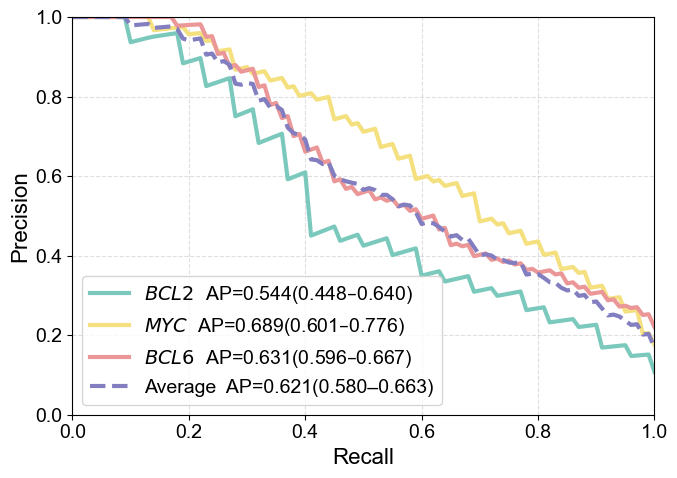

PR 曲线已保存至 ./evaluation/SXH_clinic/SXH_clinic_PR_patient.pdf


In [38]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
5-fold PR-AUC (patient level) for BCL2 / MYC / BCL6
author : you
date   : 2025-06-26
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import precision_recall_curve, average_precision_score
from pathlib import Path

# --------------------------------------------------------------
# 0. 参数
# --------------------------------------------------------------
center_name  = 'SXH_clinic'
N_FOLDS      = 5
CSV_TPL      = f'./results/{center_name}/s_{{}}_checkpoint.csv'
MAP_PATH     = './dataset_csv/SXH_with_mutation.csv'   # slide ↔ case
SAVE_PATH    = f'./evaluation/{center_name}/{center_name}_PR_patient.pdf'

agg_prob = "mean"          # slide→patient 概率聚合：mean / max / median

rcParams['font.family'] = 'DejaVu Sans'
AXIS_LABEL_SIZE = 12

# --------------------------------------------------------------
# 1. 读取 slide→case 映射（病人真值）
# --------------------------------------------------------------
map_df = pd.read_csv(MAP_PATH, dtype=str)
label_cols_raw = ["BCL2", "MYC", "BCL6"]
map_df[label_cols_raw] = map_df[label_cols_raw].astype(int)

for lab in label_cols_raw:
    map_df[f"label_{lab}"] = map_df[lab]

map_df = map_df[['case_id', 'slide_id'] + [f"label_{x}" for x in label_cols_raw]]

# --------------------------------------------------------------
# 2. 逐 fold → patient 聚合 → PR 曲线
# --------------------------------------------------------------
recall_grid = np.linspace(0, 1, 101)

fold_ap, fold_macro_ap      = [], []
interp_precs, interp_precs_macro = [], []

for fold in range(N_FOLDS):
    slide_df = pd.read_csv(CSV_TPL.format(fold))
    slide_df = slide_df.drop(columns=[c for c in slide_df.columns
                                      if c.startswith('label_')], errors='ignore')

    merged = slide_df.merge(map_df, on='slide_id', how='inner')

    prob_cols  = [c for c in merged.columns if c.startswith('prob_')]
    label_cols = [f"label_{x}" for x in label_cols_raw]

    agg_dict = {c: agg_prob for c in prob_cols}
    agg_dict.update({c: "max" for c in label_cols})

    patient_df = merged.groupby('case_id', as_index=False).agg(agg_dict)

    ap_dict, prec_dict = {}, {}
    for prob_col, label_col in zip(prob_cols, label_cols):
        y_true, y_score = patient_df[label_col], patient_df[prob_col]

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ap_dict[label_col] = average_precision_score(y_true, y_score)

        # precision_recall_curve 的 recall 升序、precision 与 recall 长度相同
        prec_interp = np.interp(recall_grid, recall[::-1], precision[::-1])
        prec_dict[label_col] = prec_interp

    fold_ap.append(ap_dict)
    interp_precs.append(prec_dict)

    # macro-AP
    fold_macro_ap.append(np.mean(list(ap_dict.values())))
    interp_precs_macro.append(np.vstack(list(prec_dict.values())).mean(axis=0))

# --------------------------------------------------------------
# 3. 折间平均
# --------------------------------------------------------------
mean_ap = {lc: np.mean([d[lc] for d in fold_ap]) for lc in label_cols}
std_ap  = {lc: np.std ([d[lc] for d in fold_ap], ddof=1) for lc in label_cols}

mean_ap_macro = np.mean(fold_macro_ap)
std_ap_macro  = np.std (fold_macro_ap, ddof=1)

mean_prec       = {lc: np.vstack([d[lc] for d in interp_precs]).mean(axis=0)
                   for lc in label_cols}
mean_prec_macro = np.vstack(interp_precs_macro).mean(axis=0)

# --------------------------------------------------------------
# 4. 输出
# --------------------------------------------------------------
print('=== 5-Fold Patient-Level AP (mean ± std) ===')
for lc in label_cols:
    print(f'{lc.replace("label_", ""):>10}: {mean_ap[lc]:.4f} ± {std_ap[lc]:.4f}')
print(f'  macro-avg: {mean_ap_macro:.4f} ± {std_ap_macro:.4f}')

# ----------------------------------------------------------
# 5. 绘图（与 ROC 脚本完全一致的风格）
# ----------------------------------------------------------
plt.figure(figsize=(7, 5))

# ---- 全局字号 ----
plt.rcParams.update({
    'font.family'      : 'Arial',
    'font.size'        : 14,
    'axes.labelsize'   : 16,
    'xtick.labelsize'  : 14,
    'ytick.labelsize'  : 14,
    'legend.fontsize'  : 14
})

colors = ['#7AC9BC', '#F4E07E', '#EB9798']   # BCL2 / MYC / BCL6

# ---- 单基因曲线 ----
for idx, lc in enumerate(label_cols):
    m, s = mean_ap[lc], std_ap[lc]
    lo, hi = m - 1.96*s, m + 1.96*s
    gene = r'$\it{' + lc.replace("label_", "") + '}$'   # 斜体
    plt.plot(recall_grid, mean_prec[lc],
             color=colors[idx], lw=3,
             label=f'{gene}  AP={m:.3f}({lo:.3f}–{hi:.3f})')

# ---- macro-average ----
m_macro, s_macro = mean_ap_macro, std_ap_macro
lo_macro, hi_macro = m_macro - 1.96*s_macro, m_macro + 1.96*s_macro
plt.plot(recall_grid, mean_prec_macro,
         color='#827EC0', lw=3, linestyle='--',
         label=f'Average  AP={m_macro:.3f}({lo_macro:.3f}–{hi_macro:.3f})')

# ---- 坐标轴 ----
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', frameon=True, shadow=False)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()

Path(SAVE_PATH).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(SAVE_PATH, dpi=300, bbox_inches='tight')
plt.show()
print(f'PR 曲线已保存至 {SAVE_PATH}')

# patient-level 评估指标

In [27]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
5-fold multi-label metrics (patient level) with per-label optimal threshold
author : you
date   : 2025-06-26
"""

import sys
from pathlib import Path
import numpy as np
import pandas as pd
from contextlib import redirect_stdout
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score,
                             roc_curve)

# ------------------------------------------------------------
# 0. 参数
# ------------------------------------------------------------
center_name    = "SXH_clinic"
RESULT_DIR     = Path(f"./results/{center_name}")
N_FOLDS        = 5
METRIC         = "youden"                         # "youden" or "f1"
MAP_PATH       = "./dataset_csv/SXH_with_mutation.csv"       # case-slide 映射 + 真值
LOG_PATH       = Path(f"./evaluation/{center_name}/"
                      f"{center_name}_patient_metrics.txt")
agg_prob       = "mean"                           # slide→patient 概率聚合: mean/max

label_cols_raw = ["BCL2", "MYC", "BCL6"]          # 映射表里真值列名

# ------------------------------------------------------------
# 0-bis. Tee：stdout 同时写文件
# ------------------------------------------------------------
class Tee:
    def __init__(self, *files): self.files = files
    def write(self, obj):
        for f in self.files: f.write(obj)
    def flush(self):
        for f in self.files: f.flush()

# ------------------------------------------------------------
# 1. 读取映射表（病人真值）
# ------------------------------------------------------------
map_df = pd.read_csv(MAP_PATH, dtype=str)
map_df[label_cols_raw] = map_df[label_cols_raw].astype(int)

for lab in label_cols_raw:                         # 添加 label_* 前缀
    map_df[f"label_{lab}"] = map_df[lab]

map_df = map_df[["case_id", "slide_id"] + [f"label_{x}" for x in label_cols_raw]]

# ------------------------------------------------------------
# 2. 工具函数
# ------------------------------------------------------------
def best_threshold(y_true: np.ndarray,
                   y_prob: np.ndarray,
                   how: str = "youden") -> float:
    if how == "youden":
        fpr, tpr, thr = roc_curve(y_true, y_prob)
        return thr[np.argmax(tpr - fpr)]
    elif how == "f1":
        thresholds = np.r_[y_prob.min() - 1e-8, np.unique(y_prob)]
        best_t, best_f1 = 0.5, -1
        for t in thresholds:
            f1 = f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        return best_t
    else:
        raise ValueError

def binary_metrics(y_true, y_pred, y_prob):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    acc  = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn) if (tp + fn) else np.nan
    spec = tn / (tn + fp) if (tn + fp) else np.nan
    prec = tp / (tp + fp) if (tp + fp) else np.nan
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auroc = roc_auc_score(y_true, y_prob)           if len(np.unique(y_true)) == 2 else np.nan
    auprc = average_precision_score(y_true, y_prob) if len(np.unique(y_true)) == 2 else np.nan
    return dict(ACC=acc, Sensitivity=sens, Specificity=spec,
                Precision=prec, F1=f1, AUROC=auroc, AUPRC=auprc,
                TP=tp, FP=fp, TN=tn, FN=fn)

# ------------------------------------------------------------
# 3. 主流程
# ------------------------------------------------------------
per_fold_class, per_fold_macro, per_fold_micro, per_fold_thr = [], [], [], []

for k in range(N_FOLDS):
    slide_df = pd.read_csv(RESULT_DIR / f"s_{k}_checkpoint.csv")

    # 3.1 删掉 slide 文件里的 label_ 列，避免冲突
    slide_df = slide_df.drop(columns=[c for c in slide_df.columns
                                      if c.startswith("label_")], errors="ignore")

    # 3.2 合并映射表 → patient-level 聚合
    merged = slide_df.merge(map_df, on="slide_id", how="inner")
    prob_cols  = [c for c in merged.columns if c.startswith("prob_")]
    label_cols = [f"label_{x}" for x in label_cols_raw]
    pred_cols  = [c.replace("prob_", "pred_") for c in prob_cols]

    agg_dict = {c: agg_prob for c in prob_cols}
    agg_dict.update({c: "max" for c in label_cols})
    patient_df = merged.groupby("case_id", as_index=False).agg(agg_dict)

    # 3.3 每标签最佳阈值
    thr_dict = {lc: best_threshold(patient_df[lc].values,
                                   patient_df[pc].values, METRIC)
                for pc, lc in zip(prob_cols, label_cols)}
    per_fold_thr.append(thr_dict)

    # 3.4 生成预测列
    for pc, lc in zip(prob_cols, label_cols):
        patient_df[pc.replace("prob_", "pred_")] = (patient_df[pc] >= thr_dict[lc]).astype(int)

    # 3.5 二分类指标（每标签）
    recs = []
    for prob_c, label_c, pred_c in zip(prob_cols, label_cols, pred_cols):
        m = binary_metrics(patient_df[label_c].values,
                           patient_df[pred_c].values,
                           patient_df[prob_c].values)
        m["Thr"]  = thr_dict[label_c]
        m["label"] = label_c.replace("label_", "")
        recs.append(m)
    fold_df = pd.DataFrame(recs).set_index("label")
    per_fold_class.append(fold_df)

    # 3.6 macro / micro 多标签指标
    y_true = patient_df[label_cols].values
    y_pred = patient_df[pred_cols].values
    per_fold_macro.append({
        "Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall"   : recall_score   (y_true, y_pred, average="macro", zero_division=0),
        "F1"       : f1_score       (y_true, y_pred, average="macro", zero_division=0)})
    per_fold_micro.append({
        "Precision": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "Recall"   : recall_score   (y_true, y_pred, average="micro", zero_division=0),
        "F1"       : f1_score       (y_true, y_pred, average="micro", zero_division=0)})

# ------------------------------------------------------------
# 4. 输出到文件 + 终端
# ------------------------------------------------------------
LOG_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(LOG_PATH, "w", encoding="utf-8") as f_log, redirect_stdout(Tee(sys.stdout, f_log)):

    for idx, df in enumerate(per_fold_class):
        print(f"\n========== Fold {idx} (patient, best-{METRIC}) ==========")
        print(df[["Thr", "ACC", "Sensitivity", "Specificity",
                  "Precision", "F1", "AUROC", "AUPRC"]].round(4))
        print("Macro avg :", {k: f"{v:.4f}" for k, v in per_fold_macro[idx].items()})
        print("Micro avg :", {k: f"{v:.4f}" for k, v in per_fold_micro[idx].items()})

    # ---- 5-折汇总 ----
    cat      = pd.concat(per_fold_class, keys=range(N_FOLDS),
                         names=["fold", "label"])
    mean_df  = cat.groupby("label").mean()
    std_df   = cat.groupby("label").std(ddof=1)

    print("\n========== 5-Fold Mean ± Std (patient level, per label) ==========")
    summary = mean_df.round(4).astype(str) + " ± " + std_df.round(4).astype(str)
    print(summary[["Thr", "ACC", "Sensitivity", "Specificity",
                   "Precision", "F1", "AUROC", "AUPRC"]])

    macro_df = pd.DataFrame(per_fold_macro)
    micro_df = pd.DataFrame(per_fold_micro)

    print("\n========== 5-Fold Macro Average ==========")
    for m in macro_df.columns:
        print(f"{m:>9}: {macro_df[m].mean():.4f} ± {macro_df[m].std(ddof=1):.4f}")

    print("\n========== 5-Fold Micro Average ==========")
    for m in micro_df.columns:
        print(f"{m:>9}: {micro_df[m].mean():.4f} ± {micro_df[m].std(ddof=1):.4f}")

print(f"\n所有结果已写入: {LOG_PATH}")


========== Fold 0 (patient, best-youden) ==========
          Thr     ACC  Sensitivity  Specificity  Precision      F1   AUROC  \
label                                                                        
BCL2   0.2891  0.8382       0.5909       0.8681     0.3514  0.4407  0.7547   
MYC    0.3412  0.8235       0.6667       0.8571     0.5000  0.5714  0.8228   
BCL6   0.4128  0.8137       0.6222       0.8679     0.5714  0.5957  0.7968   

        AUPRC  
label          
BCL2   0.4682  
MYC    0.6872  
BCL6   0.6431  
Macro avg : {'Precision': '0.4743', 'Recall': '0.6266', 'F1': '0.5360'}
Micro avg : {'Precision': '0.4851', 'Recall': '0.6311', 'F1': '0.5485'}

========== Fold 1 (patient, best-youden) ==========
          Thr     ACC  Sensitivity  Specificity  Precision      F1   AUROC  \
label                                                                        
BCL2   0.1227  0.8137       0.7727       0.8187     0.3400  0.4722  0.8244   
MYC    0.0743  0.8088       0.8333       0.80

# patient-level 二分类混淆矩阵

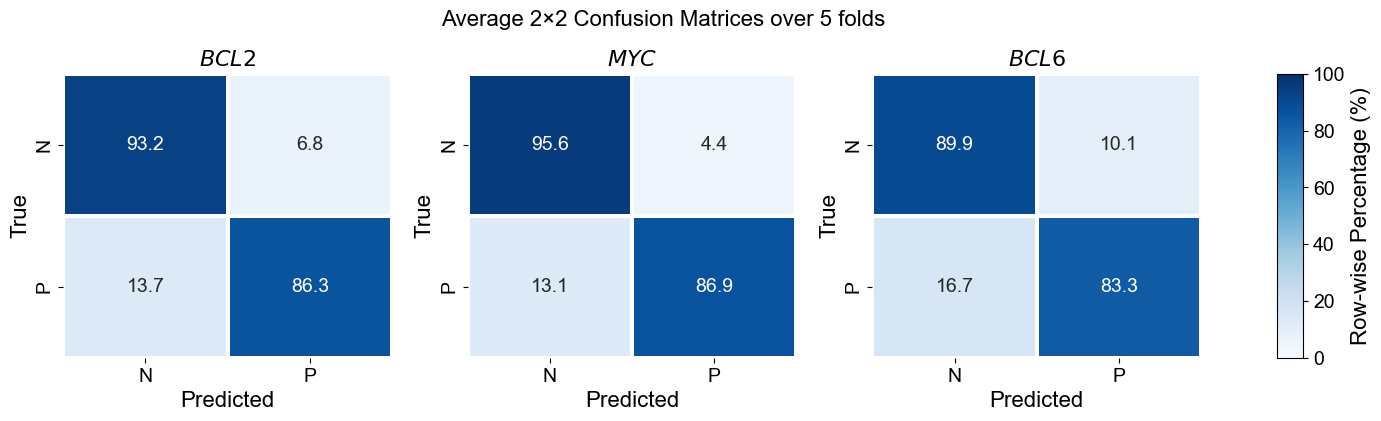

患者层面 2×2 混淆矩阵已保存至 ./evaluation/Beijing_all/Beijing_all_patient_matrix_2cls.pdf


In [45]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
2×2 patient-level confusion matrices (BCL2 / MYC / BCL6)
风格与 ROC/PR 脚本完全统一
author : you
date   : 2025-06-26
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_curve, f1_score, confusion_matrix

# ---------- 0. 全局字体：Arial + 字号 ----------
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# ------------------------ 参数 ------------------------
center_name = "Beijing_all"
N_FOLDS     = 5
CSV_TPL     = "./results/{}/s_{}_checkpoint.csv"
MAP_PATH    = "./dataset_csv/BH_TCH.csv"
METRIC      = "youden"           # "youden" or "f1"
FIG_PATH    = f"./evaluation/{center_name}/{center_name}_patient_matrix_2cls.pdf"

LABELS = ["BCL2", "MYC", "BCL6"]

# ------------------ 1️⃣ 工具函数 ------------------
def best_threshold(y_true, y_prob, how="youden"):
    if len(np.unique(y_true)) < 2:          # 全 0 或全 1
        return 0.5
    if how == "youden":
        fpr, tpr, thr = roc_curve(y_true, y_prob)
        return thr[np.argmax(tpr - fpr)]
    elif how == "f1":
        best_t, best_f1 = 0.5, -1
        for t in np.r_[y_prob.min() - 1e-8, np.unique(y_prob)]:
            f1 = f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        return best_t

# ------------------ 2️⃣ 读取映射表 ------------------
map_df = pd.read_csv(MAP_PATH, dtype=str)
map_df[LABELS] = map_df[LABELS].astype(int)
for lab in LABELS:
    map_df[f"label_{lab}"] = map_df[lab]
map_df = map_df[["case_id", "slide_id"] + [f"label_{x}" for x in LABELS]]

# ------------------ 3️⃣ 5 折累加 2×2 CM ------------------
cm_sum = {lab: np.zeros((2, 2), dtype=int) for lab in LABELS}

for fold in range(N_FOLDS):
    slide_df = pd.read_csv(CSV_TPL.format(center_name, fold))
    slide_df = slide_df.drop(columns=[c for c in slide_df.columns
                                      if c.startswith("label_")], errors="ignore")
    merged = slide_df.merge(map_df, on="slide_id", how="inner")

    prob_cols  = [f"prob_{lab}"  for lab in LABELS]
    label_cols = [f"label_{lab}" for lab in LABELS]

    # slide → patient 聚合
    agg_dict = {c: "mean" for c in prob_cols}
    agg_dict.update({c: "max" for c in label_cols})
    patient_df = merged.groupby("case_id", as_index=False).agg(agg_dict)

    # 每标签最优阈值并累加混淆矩阵
    for lab in LABELS:
        thr    = best_threshold(patient_df[f"label_{lab}"],
                                patient_df[f"prob_{lab}"], METRIC)
        y_true = patient_df[f"label_{lab}"].values
        y_pred = (patient_df[f"prob_{lab}"] >= thr).astype(int).values
        cm_sum[lab] += confusion_matrix(y_true, y_pred, labels=[0, 1])

# ------------------ 4️⃣ 行归一化 → 百分比 ------------------
cm_pct = {}
for lab, cm in cm_sum.items():
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    cm_pct[lab] = cm / row_sums

# ------------------ 5️⃣ 绘图 --------------------------
cmap = sns.color_palette("Blues", as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=100)

fig = plt.figure(figsize=(16, 4))          # 与 ROC/PR 脚本一致
gs  = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.08], wspace=0.3)
axes    = [fig.add_subplot(gs[0, i]) for i in range(3)]
cbar_ax = fig.add_subplot(gs[0, 3])

for ax, lab in zip(axes, LABELS):
    sns.heatmap(cm_pct[lab] * 100,
                annot=True, fmt=".1f",
                cmap=cmap, norm=norm, cbar=False,
                xticklabels=["N", "P"], yticklabels=["N", "P"],
                linewidths=1.5, linecolor="white",  # 加粗白框
                ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(r'$\mathit{' + lab + '}$')  # 斜体

# 独立颜色条
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, label="Row-wise Percentage (%)")

# 总标题
fig.suptitle("Average 2×2 Confusion Matrices over 5 folds", fontsize=16)
fig.subplots_adjust(top=0.82)   # 给标题留空

# 保存
Path(FIG_PATH).parent.mkdir(parents=True, exist_ok=True)
fig.savefig(FIG_PATH, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()
print(f"患者层面 2×2 混淆矩阵已保存至 {FIG_PATH}")

# paitent-level co-occurence

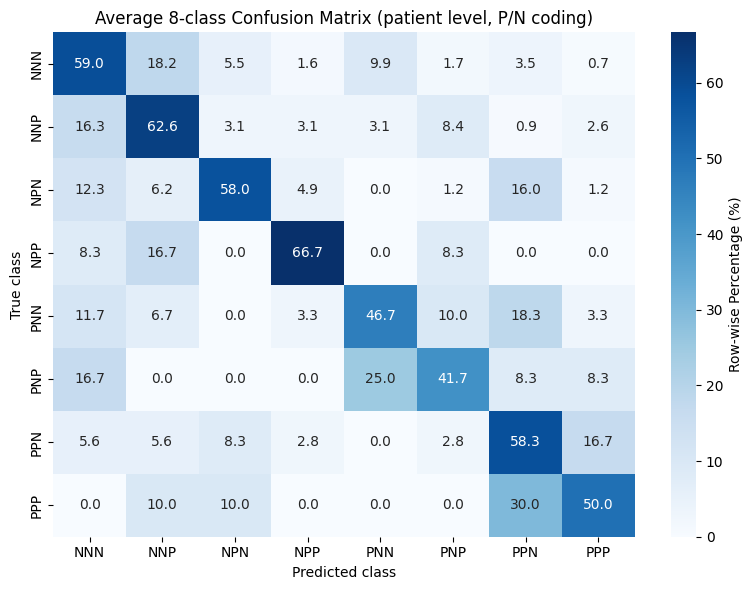

患者层面 8×8 混淆矩阵已保存至 /data/ceiling/workspace/DLBLC/evaluation/Beijing/Beijing_patient_matrix_8cls_PN.pdf


In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Build average 8-class confusion matrix (patient level, P/N coding) over 5 folds
author : you
date   : 2025-06-26
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_curve, f1_score, confusion_matrix

# -------------------------------------------------- 参数 --------------------------------------------------
center_name   = "Beijing"
N_FOLDS       = 5
CSV_TPL       = "/data/ceiling/workspace/DLBLC/results/{}/s_{}_checkpoint.csv"
MAP_PATH      = "./dataset_csv/BH_TCH.csv"            # case_id, slide_id, BCL2 …
METRIC        = "youden"                              # "youden" or "f1"
agg_prob      = "mean"                                # slide→patient 概率聚合方式
FIG_PATH      = f"/data/ceiling/workspace/DLBLC/evaluation/{center_name}/{center_name}_patient_matrix_8cls_PN.pdf"

LABELS = ["BCL2", "MYC", "BCL6"]                      # bit2, bit1, bit0
BITS   = np.array([4, 2, 1])                          # 二进制权重

# -------------------------------------------------- 1️⃣ 工具函数 --------------------------------------------------
def best_threshold(y_true, y_prob, how="youden"):
    """若 y_true 全为 0/1，直接返回 0.5；否则用 Youden/F1 选阈值"""
    if len(np.unique(y_true)) < 2:
        return 0.5
    if how == "youden":
        fpr, tpr, thr = roc_curve(y_true, y_prob)
        return thr[np.argmax(tpr - fpr)]
    elif how == "f1":
        best_t, best_f1 = 0.5, -1
        for t in np.r_[y_prob.min() - 1e-8, np.unique(y_prob)]:
            f1 = f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        return best_t
    else:
        raise ValueError("how must be 'youden' or 'f1'")

def bin_to_PN(bits: str) -> str:
    return "".join("P" if b == "1" else "N" for b in bits)

# -------------------------------------------------- 2️⃣ 读取映射表 --------------------------------------------------
map_df = pd.read_csv(MAP_PATH, dtype=str)
map_df[LABELS] = map_df[LABELS].astype(int)
for lab in LABELS:
    map_df[f"label_{lab}"] = map_df[lab]
map_df = map_df[["case_id", "slide_id"] + [f"label_{x}" for x in LABELS]]

# -------------------------------------------------- 3️⃣ 累加 8×8 混淆矩阵 --------------------------------------------------
cm_sum = np.zeros((8, 8), dtype=int)

for fold in range(N_FOLDS):
    slide_df = pd.read_csv(CSV_TPL.format(center_name, fold))

    # 去掉 slide 结果中的 label_ 列
    slide_df = slide_df.drop(columns=[c for c in slide_df.columns
                                      if c.startswith("label_")], errors="ignore")

    merged = slide_df.merge(map_df, on="slide_id", how="inner")

    prob_cols  = [f"prob_{lab}"  for lab in LABELS]
    label_cols = [f"label_{lab}" for lab in LABELS]

    # slide→patient 聚合
    agg_dict = {c: agg_prob for c in prob_cols}
    agg_dict.update({c: "max" for c in label_cols})
    patient_df = merged.groupby("case_id", as_index=False).agg(agg_dict)

    # 每标签阈值
    thr = {lab: best_threshold(patient_df[f"label_{lab}"],
                               patient_df[f"prob_{lab}"], METRIC)
           for lab in LABELS}

    # 8 类编码（真值）
    y_true_bits = patient_df[label_cols].astype(int).values           # (N,3)
    y_true_cls  = (y_true_bits * BITS).sum(axis=1)

    # 8 类编码（预测）
    pred_bits = np.column_stack([
        (patient_df[f"prob_{lab}"] >= thr[lab]).astype(int) for lab in LABELS
    ])
    y_pred_cls = (pred_bits * BITS).sum(axis=1)

    cm_sum += confusion_matrix(y_true_cls, y_pred_cls, labels=np.arange(8))

# -------------------------------------------------- 4️⃣ 行归一化 --------------------------------------------------
row_sums = cm_sum.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
cm_pct = cm_sum / row_sums

# -------------------------------------------------- 5️⃣ 绘图 --------------------------------------------------
class_names = [bin_to_PN(f"{i:03b}") for i in range(8)]   # NNN … PPP
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pct * 100,
            annot=True, fmt=".1f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws=dict(label="Row-wise Percentage (%)"))
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Average 8-class Confusion Matrix (patient level, P/N coding)")
plt.tight_layout()

Path(FIG_PATH).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(FIG_PATH, dpi=300)
plt.show()

print(f"患者层面 8×8 混淆矩阵已保存至 {FIG_PATH}")

In [54]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
指定共现模式 → 患者级 AUROC（5-fold 平均 + 95 %CI）→ CSV
author : you
date   : 2025-06-26
"""
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from pathlib import Path

# ---------- 1. 参数（只改这里） ----------
center_name = "Beijing_all"                # <<< 中心名
N_FOLDS = 5
CSV_TPL = f"./results/{center_name}/s_{{}}_checkpoint.csv"
MAP_PATH = "./dataset_csv/BH_TCH.csv"     # slide↔patient 映射

# 共现规则：list 里每个元素是一个 dict，key 为基因，value 为 0/1
PATTERNS = [
    {"name": "BCL2+MYC",       "rule": {"BCL2": 1, "MYC": 1, "BCL6": 0}},
    {"name": "BCL6+MYC",       "rule": {"BCL2": 0, "MYC": 1, "BCL6": 1}},
    {"name": "BCL2+MYC+BCL6",  "rule": {"BCL2": 1, "MYC": 1, "BCL6": 1}},
]

OUT_DIR = Path(f"./evaluation/{center_name}")
OUT_DIR.mkdir(parents=True, exist_ok=True)
SAVE_CSV = OUT_DIR / "Patient_Pattern_AUROC_Stats.csv"
# ------------------------------------------

# 读取映射
map_df = pd.read_csv(MAP_PATH, dtype=str)
for g in ["BCL2", "MYC", "BCL6"]:
    map_df[f"label_{g}"] = map_df[g].astype(int)

# 5-fold 容器
auc_fold = {p["name"]: [] for p in PATTERNS}

for fold in range(N_FOLDS):
    slide_df = pd.read_csv(CSV_TPL.format(fold))
    # 去掉自带 label_ 列避免重名
    slide_df = slide_df.drop(columns=[c for c in slide_df.columns
                                      if c.startswith("label_")], errors="ignore")
    merged = slide_df.merge(map_df, on="slide_id", how="inner")

    # 患者级聚合：概率平均，label 取 max
    patient_df = (merged
                  .groupby("case_id", as_index=False)
                  .agg({**{f"prob_{g}": "mean" for g in ["BCL2", "MYC", "BCL6"]},
                        **{f"label_{g}": "max" for g in ["BCL2", "MYC", "BCL6"]}}))

    # 共现真值 + 联合概率
    for p in PATTERNS:
        y_true = np.all(np.column_stack([
            patient_df[f"label_{g}"] == p["rule"][g] for g in ["BCL2", "MYC", "BCL6"]
        ]), axis=1)
        if y_true.sum() == 0:          # 本折无样本
            continue
        y_score = patient_df[[f"prob_{g}" for g in ["BCL2", "MYC", "BCL6"]]].mean(axis=1)
        auc_fold[p["name"]].append(roc_auc_score(y_true, y_score))

# 整理 DataFrame
df_out = pd.DataFrame([
    {
        "Pattern": p["name"],
        "mean": np.mean(auc_fold[p["name"]]),
        "ci_low": np.percentile(auc_fold[p["name"]], 2.5),
        "ci_high": np.percentile(auc_fold[p["name"]], 97.5),
    }
    for p in PATTERNS
])

df_out.to_csv(SAVE_CSV, index=False)
print(f"AUROC 统计已保存 → {SAVE_CSV.resolve()}")

AUROC 统计已保存 → /data3/ceiling/workspace/DLBCL2/evaluation/Beijing_all/Patient_Pattern_AUROC_Stats.csv
